# Preparation

Author: Yuzhu Zhang (yuzhu.zhang@deliveryhero.com)

In [1]:
#install package
!pip install --upgrade gspread

  Found existing installation: gspread 3.0.1
    Uninstalling gspread-3.0.1:
      Successfully uninstalled gspread-3.0.1


In [2]:
# load packages
#from autoplotter import run_app # Importing the autoplotter for GUI Based EDA
from datetime import datetime, timedelta, time, date
from scipy import stats
import json
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.io import gbq
from google.cloud import bigquery
import plotly.offline as pyo
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import scipy.stats
#import geopandas
from shapely import wkt
import scipy
from scipy import signal
%matplotlib inline
from google.colab import auth
auth.authenticate_user()
print('Authenticated')
cwd=os.getcwd()
cwd
%unload_ext google.colab.data_table
from google.colab import auth
auth.authenticate_user()
import gspread
from oauth2client.client import GoogleCredentials
gc = gspread.authorize(GoogleCredentials.get_application_default())

Authenticated
The google.colab.data_table extension is not loaded.


In [3]:
# define a few things (project id, start date etc.)
project_id = "fulfillment-dwh-production"
client = bigquery.Client(project = project_id)
entity_id = 'FP_LA'
country_code = 'la'
start_date = '2021-01-30'
end_date = '2021-02-22'
time_zone = "Asia/Hong_Kong" # to check delay data
#zone_id = "1,2,3,4,5,6,7,9,27,28,30,34,35,36" # 3 = Far East, If you need two zones like zone 9 and zone 35, then put "9,35" behind "="
variants= "'Control','Variation1','Variation2','Variation3'"

#add more filter: vertical type, delivery type

# Sanity Check

Before we look at the key metrics, we need to check if there are equal amount of users in control and variation group.

In [14]:
#@title Load data
query = """
SELECT  
customer.variant
, count(distinct customer.user_id) as user_count
, count(distinct customer.session.id) as session_count
FROM `fulfillment-dwh-production.cl.dynamic_pricing_user_sessions` s
WHERE created_date between \"""" + start_date + """\" and \"""" + end_date + """\"
and s.entity_id = \"""" + entity_id + """\"
and customer.variant in (""" + variants + """)
group by 1
    """

user = client.query(query).to_dataframe()

In [15]:
user

,variant,user_count,session_count
0,Variation1,93014,673226
1,Control,92955,675787


In [16]:
df_copy.pivot_table(values = ["order", "df","gfv_local","rev","profit","delivery_distance", "df_sum","gfv_sum","profit_sum","rev_sum","distance_sum", "delivery_costs", "delivery_costs_sum"], 
                             index=[ "variant"], 
                       aggfunc ={"order": "count","df":"mean","gfv_local":"mean","rev":"mean","profit":"mean","delivery_distance":"mean","delivery_costs":"mean",
                                 "df_sum":"sum","gfv_sum":"sum","rev_sum":"sum","profit_sum":"sum","distance_sum":"sum" , "delivery_costs_sum":"sum"}).reset_index()

,variant,delivery_costs,delivery_costs_sum,delivery_distance,df,df_sum,distance_sum,gfv_local,gfv_sum,order,profit,profit_sum,rev,rev_sum
0,Control,6174.111548,8.967094e+08,2.766706,0.0,0.0,401828.014,38149.077125,5.540658e+09,145237,4541.707589,6.596240e+08,10716.067008,1.556369e+09
1,Variation1,6169.012086,9.018479e+08,2.759806,0.0,0.0,403456.038,38048.241963,5.562272e+09,146190,4520.295281,6.608220e+08,10689.678802,1.562724e+09


In [28]:
data = {'variant': ['Variation1', 'Control'], 
        'user_count': [93014, 92955], 
        'session_count': [673226, 675787],
        "order_count": [146190,145237]
        } 
graph = pd.DataFrame(data)

In [29]:
graph

,variant,user_count,session_count,order_count
0,Variation1,93014,673226,146190
1,Control,92955,675787,145237


In [31]:
fig = go.Figure(data=[
    go.Bar(x=graph["variant"], y=graph["user_count"], name="user count",text= graph["user_count"],textposition='auto'),
    go.Bar(x=graph["variant"], y=graph["order_count"], name="order count",text= graph["order_count"],textposition='auto'),
    go.Bar(x=graph["variant"], y=graph["session_count"], name="session count",text= graph["session_count"],textposition='auto')0

])
# Change the bar mode
fig.update_layout(barmode='group')
fig.show()

# Analytics


## Sanity Check

In [ ]:
query = """
SELECT
created_date
, customer.variant
, count(distinct customer.user_id) as user_count
, count(distinct customer.session.id) as session_count
FROM `fulfillment-dwh-production.cl.dynamic_pricing_user_sessions` s
WHERE created_date between \"""" + start_date + """\" and \"""" + end_date + """\"
and s.entity_id = \"""" + entity_id + """\"
and customer.variant in (""" + variants + """)
group by 1,2
    """

user2 = client.query(query).to_dataframe()

In [ ]:
#user2 = user2.loc[~user2['created_date'].isin(date_list)]
user2["session/user"]=user2["session_count"]/user2["user_count"]
user2.head()

,created_date,variant,user_count,session_count,session/user
0,2021-02-18,Control,14206,26090,1.836548
1,2021-02-13,Control,14810,29092,1.964348
2,2021-01-30,Control,13925,27148,1.949587
3,2021-01-31,Variation1,14996,29750,1.983862
4,2021-02-07,Control,14806,29197,1.971971


In [ ]:
fig = px.line(user2.sort_values('created_date'), x="created_date", y="user_count", color = "variant", 
              #facet_row_spacing=0.04, # default is 0.07 when facet_col_wrap is used
              #facet_col_spacing=0.04, # default is 0.03
              height=500, width=1200, category_orders = {
                                 "variant": ["Control", "Variation1"]},
              title="Daily user count across testing period")
#fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.update_yaxes(showticklabels=True)

for axis in fig.layout:
    if type(fig.layout[axis]) == go.layout.YAxis:
        fig.layout[axis].title.text = ''

fig.show()

In [ ]:
query = """
SELECT
created_date
, extract(hour from created_at) hour
, DATETIME_TRUNC(datetime(created_at),hour)  as utc_time 
, customer.variant
, count(distinct customer.user_id) as user_count
, count(distinct customer.session.id) as session_count
FROM `fulfillment-dwh-production.cl.dynamic_pricing_user_sessions` s
WHERE created_date between \"""" + start_date + """\" and \"""" + end_date + """\"
and s.entity_id = \"""" + entity_id + """\"
and customer.variant in (""" + variants + """)
group by 1,2,3,4
    """

user3 = client.query(query).to_dataframe()

In [ ]:
fig = px.line(user3.sort_values('utc_time'), x="utc_time", y="user_count", color = "variant", 
              #facet_row_spacing=0.04, # default is 0.07 when facet_col_wrap is used
              #facet_col_spacing=0.04, # default is 0.03
              height=500, width=1200, category_orders = {
                                 "variant": ["Control", "Variation1"]},
              title="Daily session count across testing period")
#fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.update_yaxes(showticklabels=True)

for axis in fig.layout:
    if type(fig.layout[axis]) == go.layout.YAxis:
        fig.layout[axis].title.text = ''

fig.show()

In [ ]:
user_sig = user2.pivot_table(["user_count","session_count"], index=["created_date"], columns ="variant", aggfunc = {"user_count":"sum","session_count":"sum"}).reset_index()
print("user mean difference is",round(user_sig[("user_count",'Variation1')].mean()/user_sig[("user_count",'Control')].mean()-1,4),"p-value is",stats.wilcoxon(user_sig[("user_count",'Variation1')], user_sig[("user_count",'Control')])[1]/2)
print("session mean difference is",round(user_sig[("session_count",'Variation1')].mean()/user_sig[("session_count",'Control')].mean()-1,4),"p-value is",stats.wilcoxon(user_sig[("session_count",'Variation1')], user_sig[("session_count",'Control')])[1]/2)

user mean difference is -0.0005 p-value is 0.37663984429348396
session mean difference is -0.0038 p-value is 0.0686773551680931


In [4]:
query = """
WITH 

costs as (
  select
    p.entity_id,
    l.platform_order_code platform_order_code,
    sum(p.delivery_costs) delivery_costs,
  from 
    (select
      entity_id,
      country_code,
      created_date,
      order_id,
      delivery_costs,
      row_number() over(partition by entity_id, order_id order by created_date desc) as rank
    from cl.utr_timings) p
  left join cl.orders l on p.order_id = l.order_id and p.country_code = l.country_code
  where p.entity_id = \"""" + entity_id + """\"
    and rank = 1
  group by 1,2)
,

original as (
select
o.zone_name
, o.zone_id
, o.vertical_type
, cast(DATETIME(o.created_at, o.timezone) as date) as local_date
, DATETIME(o.created_at, o.timezone) as local_time
, extract(hour from DATETIME(o.created_at, o.timezone)) as local_hour
, o.vendor_code
, platform_order_code_ga
, variant
, dps_test_zone
, dps_customer_tag
, o.gfv_local
, IFNULL(oco.commission_local, p.commission_local ) as commission
, oco.commission_local as new_commission
, o.delivery_fee_local
, o.delivery_fee_local_accounting
, travel_time_distance_km
, mean_delay
, travel_time
, st_distance(vendor.location, customer.location) aerial_distance
, delivery_distance
, case when discount_type ='free-delivery' then discount_value_local * discount_ratio/100 end discount_df
, delivery_fee_original_local
, delivery_costs
from cl._dps_sessions_mapped_to_orders o
left join `dhh---analytics-apac.pandata.dim_countries` con on o.entity_id = con.entity_id
left join `dhh---analytics-apac.pandata.fct_orders` p on o.platform_order_code = p.order_code_google and p.rdbms_id = con.rdbms_id
left join cl.orders co on o.entity_id = co.entity.id and o.platform_order_code_ga = co.platform_order_code
left join costs cos on cos.entity_id =o.entity_id and cos.platform_order_code = o.platform_order_code
left join `dhh---analytics-apac.pandata_report.order_commissions` oco on o.entity_id = oco.global_entity_id and o.platform_order_code = oco.order_code
where o.entity_id = \"""" + entity_id + """\"
and variant in (""" + variants + """)
and cast(DATETIME(o.created_at, o.timezone) as date) between \"""" + start_date + """\"  and \"""" + end_date + """\"
and p.is_valid_order = true
and p.created_date_local<current_date()
and platform_order_code_ga is not null
group by 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
)

select
*,
case when discount_df is null or discount_df = 0 then delivery_fee_original_local 
else delivery_fee_original_local - discount_df end df
from original a

    """

df = client.query(query).to_dataframe()

In [5]:
def clean_data_frame(data_frame):
  data_frame["hour_block"] = data_frame["local_hour"]
  data_frame.loc[data_frame.local_hour <= 9, 'hour_block'] = 9
  data_frame.loc[data_frame.local_hour >=21, 'hour_block'] = 21
  data_frame["rev"] = data_frame["commission"] + data_frame["df"]
  data_frame["rev_sum"] = data_frame["rev"]
  data_frame["profit"] = data_frame["rev"]-data_frame["delivery_costs"]
  data_frame["profit_sum"] = data_frame["profit"]
  data_frame["df_sum"] = data_frame["df"]
  data_frame["gfv_sum"] = data_frame["gfv_local"]
  data_frame["distance_sum"] = data_frame["delivery_distance"]
  data_frame["delivery_costs_sum"] = data_frame["delivery_costs"]
  data_frame = data_frame.fillna(0)
  data_frame = data_frame[['local_date', 'local_time',
       'local_hour',  'platform_order_code_ga', 'variant', 'gfv_local', 'commission',
        'delivery_distance','delivery_costs', 'df', 'hour_block',
       'rev', 'rev_sum', 'profit', 'profit_sum', 'df_sum', 'gfv_sum','delivery_costs_sum',
       'distance_sum']]
  data_frame = data_frame.drop_duplicates()
  data_frame.rename(columns={"platform_order_code_ga":"order"}, inplace=True)
  return data_frame

df_copy = clean_data_frame(df)

In [6]:
df_copy.head()

,local_date,local_time,local_hour,order,variant,gfv_local,commission,delivery_distance,delivery_costs,df,hour_block,rev,rev_sum,profit,profit_sum,df_sum,gfv_sum,delivery_costs_sum,distance_sum
0,2021-02-04,2021-02-04 10:43:30.488551,10,b7ft-cgkb,Variation1,98000.0,17818.0,0.143,4357.107,0.0,10,17818.0,17818.0,13460.893,13460.893,0.0,98000.0,4357.107,0.143
1,2021-01-31,2021-01-31 14:43:05.492119,14,v1hl-fsfi,Control,85490.0,24900.0,0.814,4916.935,0.0,14,24900.0,24900.0,19983.065,19983.065,0.0,85490.0,4916.935,0.814
2,2021-01-31,2021-01-31 15:28:40.031900,15,e2si-q5kt,Variation1,92700.0,27000.0,3.569,4385.190,0.0,15,27000.0,27000.0,22614.810,22614.810,0.0,92700.0,4385.190,3.569
3,2021-02-19,2021-02-19 22:16:36.793369,22,x9je-xw8h,Control,63860.0,18600.0,4.624,9027.815,0.0,21,18600.0,18600.0,9572.185,9572.185,0.0,63860.0,9027.815,4.624
4,2021-02-02,2021-02-02 12:54:54.013542,12,e1rm-33tv,Variation1,41000.0,9318.0,5.491,7876.105,0.0,12,9318.0,9318.0,1441.895,1441.895,0.0,41000.0,7876.105,5.491


## Significance - Aggregated level

In [7]:
df_sig = df_copy.pivot_table(values = ["order", "df","gfv_local","rev","delivery_distance","profit","delivery_costs"], index=["local_date", "hour_block"],
                        columns = "variant",
                       aggfunc ={"order": "count","df":"sum","gfv_local":"sum","rev":"sum","delivery_distance":"sum" ,"profit":"sum","delivery_costs":"sum" }).reset_index()
df_sig = df_sig.fillna(0)

Variants = ["Variation1"]

In [8]:
df_sig

local_date hour_block  ...        rev           
variant                         ...    Control Variation1
0        2021-01-30          9  ...  5254738.0  4721770.0
1        2021-01-30         10  ...  3695125.0  3953494.0
2        2021-01-30         11  ...  6463891.0  7122564.0
3        2021-01-30         12  ...  7704730.0  8325915.0
4        2021-01-30         13  ...  7055483.0  6964731.0
..              ...        ...  ...        ...        ...
294      2021-02-21         17  ...  5389570.0  5174770.0
295      2021-02-21         18  ...  6390830.0  6392480.0
296      2021-02-21         19  ...  6900275.0  5767975.0
297      2021-02-21         20  ...  3747600.0  4809325.0
298      2021-02-21         21  ...  3487650.0  3362500.0

[299 rows x 16 columns]

In [9]:
# create empty array list
rows_list = []
metrics = ["order", "gfv_local","rev","delivery_distance","profit","delivery_costs"]

# loop the data for each zone and each stage
for metric in metrics:
  for variant in Variants:
    sum_delta = df_sig[(metric,variant)].sum()/df_sig[(metric,"Control")].sum()-1   
    sum_sig = stats.wilcoxon(df_sig[(metric,variant)], df_sig[(metric,"Control")]) [1]/2
    sum_sig_tf = sum_sig <= 0.05
    if metric != "order":
      avg_delta = (df_sig[(metric,variant)].sum()/df_sig[("order",variant)].sum())/(df_sig[(metric,"Control")].sum()/df_sig[("order","Control")].sum())-1
      avg_sig = stats.wilcoxon(df_sig[(metric,variant)]/df_sig[("order",variant)],df_sig[(metric,"Control")]/df_sig[("order","Control")])[1]/2
      avg_sig_tf = avg_sig <= 0.05
    else:
      avg_delta=0
      avg_sig = "NA"
      avg_sig_tf = "NA"
    rows_list.append([metric, variant,sum_delta,sum_sig_tf,avg_delta, avg_sig_tf])
result = pd.DataFrame(rows_list, columns=['metrics','variant','sum_delta','sum_sig',"avg_delta","avg_sig"])

def color_negative_red(val):
    color = 'green' if val == True else 'black'
    return f'color: {color}'
result.style.format({"sum_delta": "{:.2%}",
                     "avg_delta": "{:.2%}"})\
                .applymap(color_negative_red)\
                 .hide_index()\
                 .bar(align='mid', color=['#d65f5f', '#5fba7d'])\
                 .set_properties(**{'text-align': 'center'})

metrics,variant,sum_delta,sum_sig,avg_delta,avg_sig
order,Variation1,0.66%,False,0.00%,NA
gfv_local,Variation1,0.39%,False,-0.26%,False
rev,Variation1,0.41%,False,-0.25%,False
delivery_distance,Variation1,0.41%,False,-0.25%,False
profit,Variation1,0.18%,False,-0.47%,False
delivery_costs,Variation1,0.57%,False,-0.08%,False


In [10]:
df_copy.pivot_table(values = ["order", "df","gfv_local","rev","profit","delivery_distance", "df_sum","gfv_sum","profit_sum","rev_sum","distance_sum", "delivery_costs", "delivery_costs_sum"], 
                             index=[ "variant"], 
                       aggfunc ={"order": "count","df":"mean","gfv_local":"mean","rev":"mean","profit":"mean","delivery_distance":"mean","delivery_costs":"mean",
                                 "df_sum":"sum","gfv_sum":"sum","rev_sum":"sum","profit_sum":"sum","distance_sum":"sum" , "delivery_costs_sum":"sum"}).reset_index()

,variant,delivery_costs,delivery_costs_sum,delivery_distance,df,df_sum,distance_sum,gfv_local,gfv_sum,order,profit,profit_sum,rev,rev_sum
0,Control,6174.111548,8.967094e+08,2.766706,0.0,0.0,401828.014,38149.077125,5.540658e+09,145237,4541.707589,6.596240e+08,10716.067008,1.556369e+09
1,Variation1,6169.012086,9.018479e+08,2.759806,0.0,0.0,403456.038,38048.241963,5.562272e+09,146190,4520.295281,6.608220e+08,10689.678802,1.562724e+09


In [13]:
user

NameError: ignored

### Each KPIs

In [11]:
df_agg = df_copy.pivot_table(values = ["order", "df","gfv_local","delivery_distance", "df_sum","gfv_sum","distance_sum", "delivery_costs", "delivery_costs_sum","rev","rev_sum","profit","profit_sum"], 
                             index=["local_date", "variant"], 
                       aggfunc ={"order": "count","df":"mean","gfv_local":"mean","delivery_distance":"mean","delivery_costs":"mean","rev":"mean","rev_sum":"sum","profit":"mean","profit_sum":"sum",
                                 "df_sum":"sum","gfv_sum":"sum","distance_sum":"sum" , "delivery_costs_sum":"sum"}).reset_index()

In [12]:
fig = px.line(df_agg, x="local_date", y="order", color = "variant", 
              #facet_row_spacing=0.04, # default is 0.07 when facet_col_wrap is used
              #facet_col_spacing=0.04, # default is 0.03
              height=500, width=1200,
              title="Aggregated order amount across testing period")

# Set x-axis title
fig.update_xaxes(title_text="Date")
# Set y-axes titles
#fig.update_yaxes(title_text="Order Amount", showgrid=False)

fig.show()

### Zone analysis

In [ ]:
def gen_graph(metric):
    fig, axes = plt.subplots(2, 2, figsize=(18, 10))
    fig.suptitle(metric)
    df_agg = df.pivot_table(values = ["order","profit", "delivery_fee_local_accounting","df","gfv_local","rev","rev_sum","delivery_distance",], index=["local_date", "variant"], 
                       aggfunc ={"order": "count","profit":"sum","delivery_fee_local_accounting":"sum","df":"sum","gfv_local":"sum","rev":"sum","delivery_distance":"sum" }).reset_index()
    df_agg["avg_df"] = df_agg["df"] / df_agg["order"]
    df_agg["avg_gfv"] = df_agg["gfv_local"] / df_agg["order"]
    df_agg["avg_revenue"] = df_agg["rev"] / df_agg["order"]
    df_agg["avg_delivery_distance"] = df_agg["delivery_distance"] / df_agg["order"]
    sns.boxplot(ax=axes[0,0], data=df, x='variant', y=metric)
    sns.countplot(ax=axes[0,1], data=df, x='variant')
    sns.lineplot(ax=axes[1,0],data=df_agg, x="local_date", y=metric,hue="variant")
    sns.distplot(ax=axes[1,1], x=df[metric],kde=True, bins=50)
    return fig.show()

def sig_check_daily(metric):
  print(gen_graph(metric))
  date_list = df_sig[('local_date',)].unique().tolist()
  new_list = []
  for variant in Variants:
      for local_date in date_list:
          df_metrics = df_sig[df_sig[("local_date",)] <= local_date]
          sum_delta = df_metrics[(metric,variant)].sum()/df_metrics[(metric,"Control")].sum()-1
          sum_pvalue = stats.wilcoxon(df_metrics[(metric,variant)], df_metrics[(metric,"Control")]) [1]/2
          sum_sig = sum_pvalue<= 0.05
          if metric != "order":
              avg_delta = (df_metrics[(metric,variant)].sum()/df_metrics[("order",variant)].sum())/(df_metrics[(metric,"Control")].sum()/df_metrics[("order","Control")].sum())-1
              avg_pvalue = stats.wilcoxon(df_metrics[(metric,variant)]/df_metrics[("order",variant)],df_metrics[(metric,"Control")]/df_metrics[("order","Control")])[1]/2
              avg_sig = avg_pvalue <= 0.05
          else:
            avg_delta=0
            avg_pvalue = 0
            avg_sig = "NA"
          new_list.append([local_date,variant,sum_delta,sum_pvalue,sum_sig,avg_delta,avg_pvalue,avg_sig])
  result = pd.DataFrame(new_list, columns=["local_date",'variant','sum_delta',"sum_pvalue","sum_sig","avg_delta","avg_pvalue","avg_sig"])
  print(result.to_string(float_format=lambda x: '{:.2%}'.format(x)))
  #fig = make_subplots(rows=2, cols=2)
  #fig.add_trace( go.Scatter(x=result.local_date, y=result.sum_delta,mode="lines"), row=1, col=1)
  #fig.add_trace( go.Scatter(x=result.local_date, y=result.sum_pvalue), row=1, col=2)
  #fig.add_trace( go.Scatter(x=result.local_date, y=result.avg_delta), row=2, col=1)
  #fig.add_trace( go.Scatter(x=result.local_date, y=result.avg_pvalue), row=2, col=2)
  #fig1 = px.line(result, x="local_date", y="sum_delta", color = "variant", height=600, width=1200)
  #fig2 = px.line(result, x="local_date", y="sum_pvalue", color = "variant", height=600, width=1200)
  #fig3 = px.line(result, x="local_date", y="avg_delta", color = "variant", height=600, width=1200)
  #fig4 = px.line(result, x="local_date", y="avg_pvalue", color = "variant", height=600, width=1200)
  fig, axes = plt.subplots(2, 2, figsize=(18, 10))
  fig.suptitle(metric)
  sns.lineplot(ax=axes[0,0],data=result, x="local_date", y="sum_delta",hue="variant")
  sns.lineplot(ax=axes[0,1],data=result, x="local_date", y="sum_pvalue",hue="variant")
  sns.lineplot(ax=axes[1,0],data=result, x="local_date", y="avg_delta",hue="variant")
  sns.lineplot(ax=axes[1,1],data=result, x="local_date", y="avg_pvalue",hue="variant")
  return fig.show()

KeyError: ignored

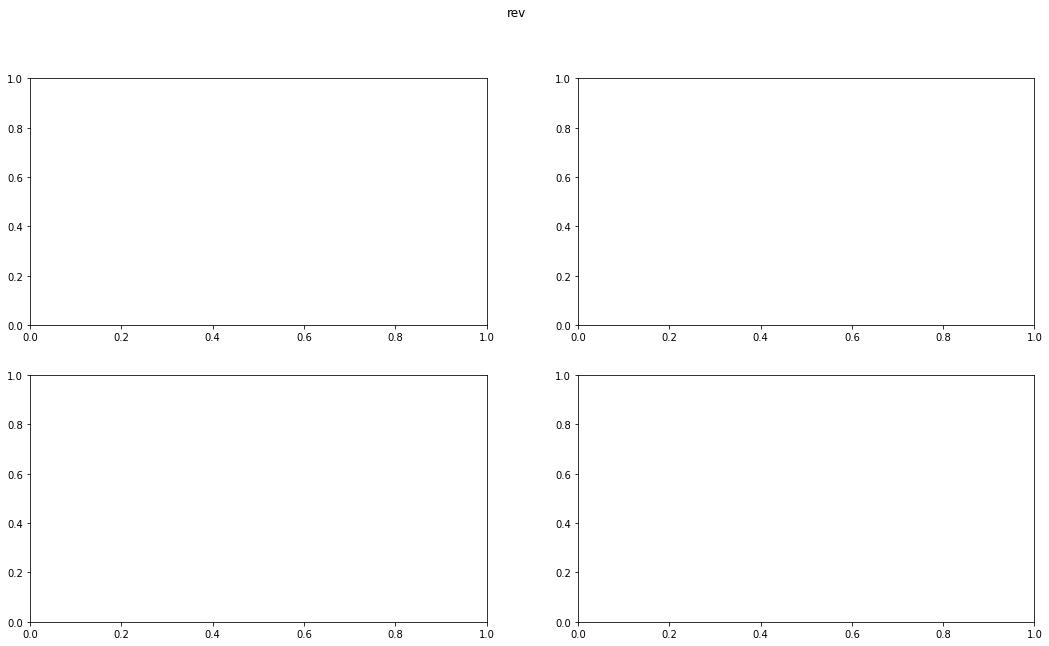

In [ ]:
sig_check_daily("rev")